In [10]:
from src.utils import get_dataset
from src.vae.mnist_vae import ConditionalVae
import matplotlib.pyplot as plt
from src.impute import impute_cvae_naive
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from src.image_classifier.exq_net_v1 import ExquisiteNetV1
import torch
from torch import nn, optim
from torchvision.transforms import transforms
from torchvision import datasets
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# binarize the data
class args:
    def __init__(self):
        self.num_channels = 1
        self.iid = 1
        self.num_classes = 10
        self.num_users = 10
        self.dataset = 'fmnist'

training_data, testing_data, user_groups = get_dataset(args())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
  

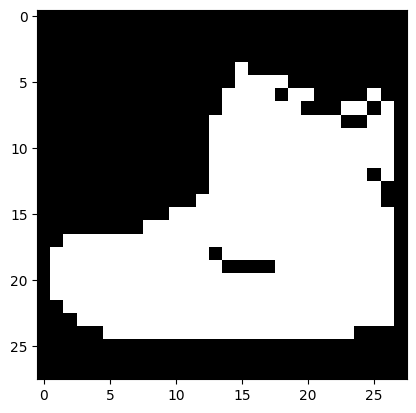

In [12]:
plt.imshow(training_data[0][0][0], cmap='gray')

print(training_data[0][0][0])

In [ ]:
# Use VAE to generate some data
cvae = ConditionalVae(dim_encoding=3).to('cuda:0')

# try with model sigma
cvae_model, vae_loss_li, kl_loss_li, reg_loss_li = cvae.train_model(
    training_data=training_data,
    batch_size=32,
    epochs=20,
    learning_rate=0.001
)

vl_loss: 30587.828125
Finished epoch:  1
vl_loss: 57885.77734375
Finished epoch:  2


In [ ]:
# generate synthetic data
gen_dataset = impute_cvae_naive(k=60000, trained_cvae = cvae_model, initial_dataset = torch.tensor([]))

In [ ]:
# train classifier on gen data
train_loader= DataLoader(gen_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=True)

# Assuming 'model' is your model
classifier = ExquisiteNetV1(class_num=10, img_channels=1)
classifier = classifier.to(device)  # Move model to GPU if available

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Number of epochs to train the model
n_epochs = 20
train_losses = []
test_losses = []
f1_scores = []
correct_predictions = 0
total_predictions = 0
for epoch in tqdm(range(n_epochs)):
    train_loss = 0.0
    pred_labels = []
    actual_labels = []
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = classifier(data)
        pred_labels.append(output.argmax(dim=1))
        actual_labels.append(target)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * data.size(0)

    # Switch to evaluation mode
    classifier.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_pred_labels = []
        test_actual_labels = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            test_pred_labels.append(output.argmax(dim=1))
            test_actual_labels.append(target)
             # Compare with actual classes
            total_predictions += output.argmax(dim=1).size(0)
            # correct_predictions += (predicted == labels).sum().item()
            correct_predictions += (output.argmax(dim=1) == target).sum().item()
            
    # Compute average test loss
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    train_losses.append(train_loss)
    
    # Calculate F1 score for the test data
    test_pred_labels = torch.cat(test_pred_labels).to('cpu').numpy()
    test_actual_labels = torch.cat(test_actual_labels).to('cpu').numpy()
    test_f1_score = f1_score(test_actual_labels, test_pred_labels, average='macro')
    f1_scores.append(test_f1_score)
    accuracy = correct_predictions / total_predictions

    print(f'Accuracy: {accuracy * 100}%')
    print('Epoch: {} \tTraining Loss: {:.6f} \t Test Loss: {:.6f} \tF1 Test Macro: {:.6f}'.format(
        epoch + 1,
        train_loss,
        test_loss,
        test_f1_score
    ))


In [ ]:
# test classifier with real testing data
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)

        # Pass the data to the model
        outputs = classifier(data)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Compare with actual classes
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100}%')

In [ ]:
# test classifier with real testing data
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.round(x))])
data_dir = '../data/fmnist/'
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True,
                               transform=apply_transform)
test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True,
                              transform=apply_transform)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=True)

correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)

        # Pass the data to the model
        outputs = classifier(data)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Compare with actual classes
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100}%')